In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from matplotlib import cm
from astropy.time import Time
from astropy.coordinates import SkyCoord,EarthLocation
from astropy import units as u
Cmap = cm.jet
Cmap.set_under("w")
%matplotlib inline

In [2]:
def trajectory(time,lon = -118.3011,lat = 28.9733):
    """
    Calculates trayectories for the antenna in a given time.
    Returns an array of l and b galactic coordinates values in degrees, for a given location.
    
    It is asummed that the antenna is looking derectly to the zenit, 
    so in this case the right ascention (RA) is equal to the local sideral time of the location 
    and the declination (DEC) is equal to the latitude.
    
    Parameters:
    time: local time of observation, can be an array or a single time. Prefered format is
          'yyyy-mm-dd hh:mm:ss'. 
    
    Optional parameters:
    lon: Default longitude is given for Isla de Guadalupe at -118.3011 degrees
    lat: Default latitude is given for Isla de Guadalupe at 28.9733 degrees
    """
    t = Time(time, location =(lon,lat))
    RA = np.array(t.sidereal_time('mean').degree)
    DEC = lat*np.ones(len(RA))
    coords = SkyCoord(ra=RA*u.degree,dec=DEC*u.degree)
    l = coords.galactic.l.degree
    b = coords.galactic.b.degree
    return l,b

In [3]:
dates =  ['2018-04-03 00:00:00','2018-04-03 23:59:59']
T = Time(dates)
dt = T[1]-T[0]
times = T[0] + dt*np.linspace(0.,1.,300)

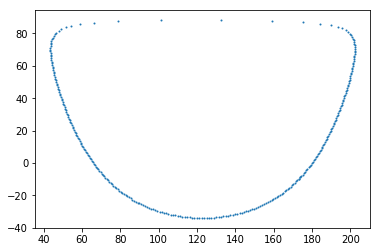

In [4]:
l_gal,b_gal = trajectory(times)
plt.plot(l_gal,b_gal,'o',markersize=1)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


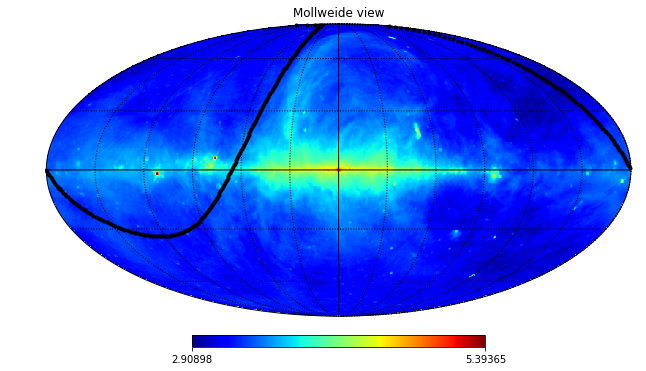

In [5]:
infile = "fore_70.txt"
bmap_gal = np.loadtxt(infile,unpack=True)
bmap_gal = np.log10(bmap_gal)
hp.mollview(bmap_gal,cmap=Cmap)
hp.graticule()
hp.projplot(l_gal, b_gal,'.k',lonlat=True)

In [6]:
def Pattern(time,infile,lon = -118.3011,lat = 28.9733):
    """
    Calculates the beam pattern for the antenna at a given time.
    Returns an array of l and b galactic coordinates values in degrees of the antenna pattern, 
    for a given location and day.
    
    It also returns an array of Temperature lecture of the antenna for a given coordinate (l,b)
    
    Parameters:
    time: local time of observation, can be an array or a single time. Prefered format is
          'yyyy-mm-dd hh:mm:ss'. 
    infile: File path of the antenna pattern in ISO coordinates.
    
    Optional parameters:
    lon: Default longitude is given for Isla de Guadalupe at -118.3011 degrees
    lat: Default latitude is given for Isla de Guadalupe at 28.9733 degrees
    """
    t = Time(time, location =(lon,lat))
    LST = np.array(t.sidereal_time('mean').degree)
    theta,phi,Temp = np.loadtxt(infile,unpack=True)
    theta,phi = np.radians(theta),np.radians(phi)
    X,Y,Z = np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)  
    Rxy = np.sqrt(X**2.+Y**2.)
    colat,Az = np.arctan2(Rxy,Z),np.arctan2(Y,X)
    Alt = 90.- np.degrees(colat)
    Alt,lat = np.radians(Alt),np.radians(lat)
    sinDEC = np.sin(Alt)*np.sin(lat)+np.cos(Alt)*np.cos(lat)*np.cos(Az)
    DEC = np.arcsin(sinDEC)
    sinH = -np.sin(Az)*np.cos(Alt)/np.cos(DEC)
    H = np.arcsin(sinH)
    DEC = np.degrees(DEC)
    RA = LST - np.degrees(H)
    coords = SkyCoord(ra=RA*u.degree,dec=DEC*u.degree)
    l = coords.galactic.l.degree
    b = coords.galactic.b.degree
    return l,b,Temp

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


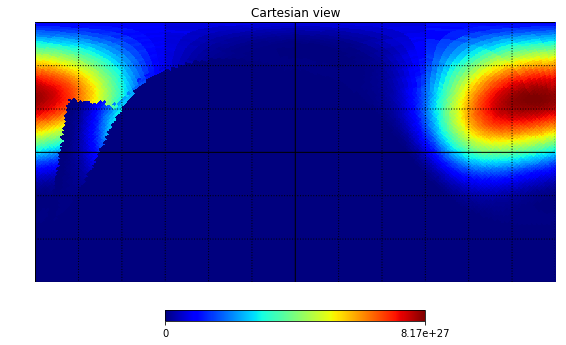

In [7]:
l,b,Temp = Pattern(time = '2013-06-01 00:00:00', infile = "70MHz.txt")
nside = 32
pix = hp.ang2pix(nside,l, b, lonlat=True)
bmap = np.zeros(hp.nside2npix(nside))
bmap[pix] = Temp
hp.cartview(bmap,cmap=Cmap)
hp.graticule()